<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/master/02-Machine-Learning/notebooks/08-Naive-Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Naive Bayes

En esta notebook implementaremos un clasificador Naive-Bayes para resolver problemas de clasificación de texto. Además, mostraremos cómo usar la implementación de scikit-learn.

In [ ]:
import pandas as pd
import numpy as np

Traemos la carpeta 'data' desde el repositorio de github

In [ ]:
# !apt-get -qq install subversion
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP/trunk/02-Machine-Learning/data/"

Checked out revision 191.


## Archivo de datos preprocesados

* El dataframe contiene una matriz BOW.

$$\begin{array}{cccc}
    & doc_1 & ... & doc_n \\
w_1 & 0 & ... & 1 \\
... & ... & ... & ... \\
w_k & 2 & ... & 1 
\end{array}$$

donde $w_i$ es la $i$-sima palabra en el corpus y $doc_j$ es el $j$-simo documento (email).

* Son 1000 correos y 9406 palabras.

* Los correos vienen etiquetados de la siguiente forma: `correo_enron1_<0/1>_<#email>` donde 

    * 0: Ham 
    * 1: Spam

In [ ]:
data = pd.read_csv('data/frecuencia_palabras.csv',index_col=0) # lectura del documento con pandas

print(data.shape)
data.head()

(9406, 1001)


,WORD,correo_enron1_0_0,correo_enron1_0_1,correo_enron1_0_2,correo_enron1_0_3,correo_enron1_0_4,correo_enron1_0_5,correo_enron1_0_6,correo_enron1_0_7,correo_enron1_0_8,...,correo_enron1_1_490,correo_enron1_1_491,correo_enron1_1_492,correo_enron1_1_493,correo_enron1_1_494,correo_enron1_1_495,correo_enron1_1_496,correo_enron1_1_497,correo_enron1_1_498,correo_enron1_1_499
0,fw,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,everyone,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,access,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,change,1,0,0,0,5,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,security,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


Algunas palabras

In [ ]:
list(data['WORD'].values[:15])

['fw',
 'everyone',
 'access',
 'change',
 'security',
 'reason',
 'brandee',
 'process',
 'initiate',
 'request',
 'get',
 'approve',
 'email',
 'addition',
 'network']

Extraemos $X$, $y$ del conjunto de datos

In [ ]:
y = np.array([0 if 'correo_enron1_0' in col else 1 for col in data.columns.to_list()[1:]])

X = data.iloc[:,1:].values.T

print(X.shape,y.shape)

(1000, 9406) (1000,)


Separamos en conjunto de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,random_state=40)

In [ ]:
print(f"Correos de Entrenamiento: {X_train.shape[0]}; Features (palabras): {X_train.shape[1]}")
print(f"Correos de Pruba: {X_test.shape[0]}; Features (palabras): {X_test.shape[1]}")
print("Clases de Prueba:")
print(y_test)

Correos de Entrenamiento: 800; Features (palabras): 9406
Correos de Pruba: 200; Features (palabras): 9406
Clases de Prueba:
[0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0
 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0
 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0
 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1]


## Entrenamiento - NAIVE BAYES MULTINOMIAL

En el caso de un problema de clasificación de documentos, consideramos el vocabulario del conjunto de documentos. Cada documento es considerado como la secuencia del número de ocurrencias de cada palabra del vocabulario dentro del documento.


Entonces, la distribución multinomial nos dice cuál es la probabilidad de que un documento pertenezca a una clase $y_j$.


---



La distribución de probabilidad de la Variable Aleatoria $\textrm{x}$ es una distribución multinomial (conteos de palabras) de la conjunción de palabras únicas, es decir del vocabulario, el cual es denotado por $V$.

$P(x_i|y_j)$ nos dice qué tan probable es que la palabra $x_i$ aparezca en la clase $j$. Esta probabilidad está dada por:

$$ P(x_i|y_j) = \theta_i^j=\frac{n_i + 1}{|S_j| + k} ;\;\;\;
\begin{array}{l}
i=1,2,\ldots,k \\
j\in\{\text{Spam},\text{Ham}\}
\end{array}
$$

* $|S_j|$ es la suma de los conteos de todas las palabras para la clase $y_j$. 
* $k=|V|$ es la longitud del vocabulario, el número de palabras únicas.
* $n_i$ es la suma de los conteos para la palabra $i$ en la case $y_j$.

Por la forma de calcular la probabilidad queremos evitar que $\theta_i^j=0$.

Al final obtenemos dos vectores $\theta_0$ y $\theta_1$:

* $\theta_0=(\theta_1^{\text{Spam}},\ldots,\theta_k^{\text{Spam}})$, nos dice la probabilidad de que cada palabra aparezca en correos *Spam*.
* $\theta_1=(\theta_1^{\text{Ham}},\ldots,\theta_k^{\text{Ham}})$, nos dice la probabilidad de que cada palabra aparezca en correos *Ham*.

Observar que 

$$\sum_{i=1}^k \theta_i^{\text{Ham}}=1,\;\;\sum_{i=1}^k \theta_i^{\text{Spam}}=1$$

Entrena al modelo para obtener los vectores $\theta_0$ y $\theta_1$. utiliza la fórmula para $P(x_i|y_j)$.

Crea una función que reciba un arreglo o un dataframe $X_{train}$ y devuelva dos vectores: $\theta_p$ y $\theta_n$.

In [ ]:
def fit(X_train,y_train):
    """
    Entrenamiento del clasificador NAIVE BAYES:
    Entrada: 
     - X_train: un DataFrame o Arreglo con instancias de entrenamiento.
    Salida:
     - una lista: [theta_n,theta_p] conteniendo 
       los vectores (np.arrays) de probabilidad de cada feature (palabra) 
       en correos Ham y Spam respectivamente. 
    """
    correos,k = X_train.shape # numero de palabras
    print(f"numero de palabras: {k}")
    print(f"número de correos: {correos}")
    theta = []
    for j in range(2):
        x_train_clase = X_train[y_train==j]
        n = np.sum(x_train_clase,axis=0)+1        # calcula n_i para cada palabra
        S = np.sum(x_train_clase)+k               # calcula |S_j|+k
        print(n)
        theta.append(n/S)                 # calcula theta correspondiente
    print('theta shapes=',theta[0].shape,theta[1].shape) #debe ser (k,) para ambos

    return theta[0],theta[1]

**Entrena el modelo**

In [ ]:
theta_n, theta_p = fit(X_train,y_train)

numero de palabras: 9406
número de correos: 800
[35 19 21 ...  1  1  1]
[ 5 12 13 ...  2  2  2]
theta shapes= (9406,) (9406,)


In [ ]:
theta_n.shape, theta_p.shape

((9406,), (9406,))

In [ ]:
print("La suma para vector debe ser 1 \n Theta_p : ",np.sum(theta_p))
print("La suma para vector debe ser 1 \n Theta_n : ",np.sum(theta_n))

La suma para vector debe ser 1 
 Theta_p :  1.0
La suma para vector debe ser 1 
 Theta_n :  1.0


## Prueba del Modelo

La función que calcula la verosimilitud está dada por

$$ p(\textrm{x}|\theta) =  \prod_{i=1}^{k} p(x_i|\theta) = n!\times\frac{\theta_{1}^{x_1}}{x_1!}\times...\times\frac{\theta_k^{x_k}}{x_k!}$$

donde $\textrm{x}=(x_1,...,x_k)$ es el documento dado por los conteos de las palabras, $\theta\in\{\theta^\text{Spam},\theta^\text{Ham}\}$ y $n=\sum x_i$.

La función de verosimilitud nos dice qué tanto una clase $j$ explica (hace creíbles) los datos $\textrm{x}$. 

<br>


---

<br>

La implementación de la distribución de probabilidad de arriba puede llevar a errores numéricos por términos $x_i$ muy grandes o $\theta_i$ muy pequeños. Por lo tanto calculamos la *verosimilitud logarítmica*:

$$ \log(p(\textrm{x}|\theta)) =  \log(n!) + x_1\log(\theta_{1})-\log(x_1!)+ ... + x_k\log(\theta_{k})-\log(x_k!)$$

Después usamos la exponencial para obtener $p(\textrm{x}|\theta)$. 


* Se recomienda usar:
  - `np.math.log` para escalares
  - `np.log` para arreglos
  - `np.math.factorial` para escalares 
  - `scipy.special.factorial` para arreglos.
  - `np.math.exp` como inverso de `log`

In [ ]:
from scipy.special import factorial

def P_Mi(x,theta):
    """
    Cálcula la función de verosimilitud: P(x|theta)
    Entrada:
     - x: arreglo unidimensional de datos
     - theta: arreglo unidimensional de probabilidades dim(theta)=dim(x)
    Salida:
     - Valor de log(P(x|theta)) según distribución MULTINOMIAL de x
    """
    if not isinstance(x,np.ndarray):  
        raise TypeError('Error, x debe ser de tipo numpy.ndarray')
        
    P_x = 0
    
    '''
    SOLUCIÓN 1: USANDO UN CICLO 'FOR'
    '''  
    # prod = 0   
    # n_i = 0  
    # for i in range(len(x)):
    #     n_i += x[i]
    #     prod += (x[i]*np.math.log(theta[i]) - np.math.log(np.math.factorial(x[i])))
    # n_fact = np.math.log(np.math.factorial(n_i))
    # P_x = prod + n_fact

    '''
    SOLUCIÓN 2: USANDO VECTORIZACIÓN DE NUMPY (MÁS RÁPIDO)
    '''  
    P_x = x*np.log(theta)-np.log(factorial(x))
    P_x = np.sum(P_x)
    n = np.sum(x)
    P_x += np.math.log(np.math.factorial(n))
    """ ------------- """
    
    return np.math.exp(P_x)

Definimos la función que clasifica X mediante el criterio LR:<br> <br>

$$ LR = \frac{p(\textrm{x}|\theta_{Pos})}{p(\textrm{x}|\theta_{Neg})}$$


Este modelo utiliza la razón de verosimilitud (LR) para hacer la predición de la clase del documento $\textrm{x}$.

* Si $LR > 1$ $\Rightarrow$ $y=1$ <br>
* Si $LR < 1$ $\Rightarrow$ $y=0$ <br>

In [ ]:
def clasifica_LR(X_test,theta_p, theta_n):
    """
    Calcula: LR=P(x|y=+)/P(x|y=-)
    Entrada:
     - X_test: arreglo o DataFrame de datos
     - theta_p: arreglo unidimensional de probabilidades Pos
     - theta_n: arreglo unidimensional de probabilidades Neg
    Salida:
     - Valor de LR
    """
    instancias = X_test.shape[0]
    y = np.zeros(instancias)
    if not isinstance(X_test,np.ndarray):
        X_ = X_test.values
    else:
        X_ = X_test 
    for i in range(instancias):
        pos = P_Mi(X_[i,:],theta_p)
        neg = P_Mi(X_[i,:],theta_n)
        try:
            lr = pos/neg
        except:
            lr = 1
        if lr>=1:
            y[i] = 1
        else:
            y[i] = 0
    return y.astype(int)    

## Evaluamos el modelo

La siguiente función predice las etiquetas de un conjunto de prueba.

Recibe el arreglo de datos de prueba, el vector theta positivo y negativo para el LR.

In [ ]:
y_predic = clasifica_LR(X_test,theta_p, theta_n)
print(y_predic)

[0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0
 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0
 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0
 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1]


Evaluamos la tarea de predicción usando las métricas de desempeño y la matriz de confusión

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(y_test,y_predic)}")
print(f"Recall: {recall_score(y_test,y_predic)}")
print(f"Precision: {precision_score(y_test,y_predic)}")

Accuracy: 0.945
Recall: 0.9519230769230769
Precision: 0.9428571428571428


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_predic)
cm

array([[90,  6],
       [ 5, 99]])

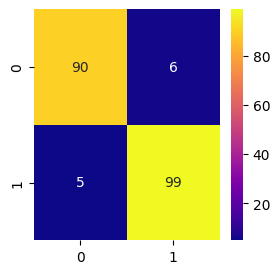

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
sns.heatmap(cm,cmap='plasma',annot=True)
plt.show()

# ⭕ Práctica

Trabajaremos con el corpus `20newsgroups`. Este es un conjunto de documentos conteniendo cerca de 18000 posts perteneciendo a 20 temas. Tomaremos documentos pertenecientes a 2 temas (*autos* y *ateísmo*). Usaremos nuestro clasificador y la implementación del Naive-Bayes de scikit-learn para hacer la clasificación. 

Usaremos el módulo `nltk`, el cual contiene herramientas para el PLN.

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Bajamos la colección de signos de puntuación y *stopwords* para hacer el preprocesamiento. Las stopwords (palabras vacías) son palabras sin significado como artículos, pronombres, preposiciones, etc. que son filtradas antes o después del procesamiento de datos en lenguaje natural.

In [ ]:
from nltk import download

download('stopwords')
download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Bajamos el conjunto de documentos

In [ ]:
from sklearn.datasets import fetch_20newsgroups

(Docs,Y) = fetch_20newsgroups(
                        categories=['rec.autos','alt.atheism'],
                        remove=('headers', 'footers', 'quotes'),
                        return_X_y=True
                        )

Vista previa de los primeros 3 documentos

In [ ]:
Docs[:3]

["\n\nI lived in Tokyo for a year and a half, and one of the many reasons why\nI intend to go back indefinitely is the freedom one enjoys when one can\nwalk anywhere (and I mean *anywhere*) at any time of day or night and not\nfeel uneasy, even if one's from an ethnic minority as I was.\n\nClues for Bobby (why do I bother?): (i) Tokyo is a city, and inner Tokyo\nis an inner city; (ii) there is a negligible level of violent crime, and\na street murder will be a lead item on *national* TV news; (iii) the\npopulation is almost universally atheistic.\n\nNext time I go for a stroll around Beirut at night, I'll let you know how\nit compares.\n\n\nCheers\n\nSimon",
 '\n\nReading newspapers to learn about this kind of stuff is not the best idea in\nthe world.  Newspaper reporters are notoriously ignorant on the subject of\nreligion, and are prone to exaggeration in the interests of having a "real"\nstory (that is, a bigger headline).\n\nLet\'s back up to 1935.  At this point, we have the Masor

In [ ]:
Y

array([0, 0, 0, ..., 1, 1, 1])

Función para preprocesar el texto, limpiarlo y quitar *stopwords*. 

Esta función usa expresiones regulares, las cuales son muy útiles en el tratamiento de texto. Más información: https://regex101.com/



In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def preprocesar_textos(docs,ignore_list:list=[]):
    strings_list = [re.sub(r'\n', '', x.lower()) for x in docs]
    strings_list = [re.sub(r'[^\w\s]', '', x.lower()) for x in docs]  # quita signos de puntuación
    strings_list = [re.sub('[0-9]', '', x.lower()) for x in strings_list] # quita números
    SW = stopwords.words('english') 
    for x in ignore_list: # quitamos stopwords
        SW.remove(x)
    tokens_no_sw = [" ".join([word for word in word_tokenize(text) if not word in SW]) for
                         text in strings_list ]
    return tokens_no_sw

Vista previa de los primeros 3 documentos ya preprocesados

In [ ]:
documentos = preprocesar_textos(Docs)
documentos[:3]

['lived tokyo year half one many reasons intend go back indefinitely freedom one enjoys one walk anywhere mean anywhere time day night feel uneasy even ones ethnic minority clues bobby bother tokyo city inner tokyo inner city ii negligible level violent crime street murder lead item national tv news iii population almost universally atheistic next time go stroll around beirut night ill let know compares cheers simon',
 'reading newspapers learn kind stuff best idea world newspaper reporters notoriously ignorant subject religion prone exaggeration interests real story bigger headline lets back point masoretic text various targums translationscommentaries aramaic etc septuagint ancient greek translation masoretic text standard jewish text essentially vary places obvious corruptions copied faithfully copy copy passages past interpreted reference targums septuagint septuagint differs masoretic text two particulars first includes additional texts second passages variant readings masoretic t

`CountVectorizer` crea la matriz de términos-documentos necesaria para aplicar nuestro Naive-Bayes multinomial.

** Prueba cambiando el parámetro `max_features`

*Revisar https://docs.scipy.org/doc/scipy/reference/sparse.html

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_features=8000)
X = vec.fit_transform(documentos)

X = np.array(X.todense())

print(X.shape)

(1074, 8000)


Diccionario que contiene el índice de cada palabra en el vocabulario

In [ ]:
vec.vocabulary_

Separamos en train/test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.8,random_state=9)

## Usando nuestro clasificador

Recupera la función de entrenamiento implementada en el ejercicio de SPAM. Es decir, copiala aquí y modificala si es necesario.

In [ ]:
def fit(X_train,y_train):
    
    '''
    Entrenamiento del clasificador NAIVE BAYES:
    Entrada: 
     - X_train: un DataFrame o Arreglo con instancias de entrenamiento.
    Salida:
     - una lista: [theta_n,theta_p] conteniendo 
       los vectores (np.arrays) de probabilidad de cada feature (palabra) 
       en correos Ham y Spam respectivamente. 
    llena el código
    '''
    documentos,k = X_train.shape # numero de palabras
    print(f"numero de palabras: {k}")
    print(f"número de documentos: {documentos}")
    theta = []
    for j in range(2):
        x_train_clase = X_train[y_train==j]
        n = np.sum(x_train_clase,axis=0)+1        # calcula n_i para cada palabra
        S = np.sum(x_train_clase)+k               # calcula |S_j|+k
        print(n)
        theta.append(n/S)                 # calcula theta correspondiente
    print('theta shapes=',theta[0].shape,theta[1].shape) #debe ser (k,) para ambos


    return theta[0],theta[1]

Entrenamos el modelo

In [ ]:
theta_n, theta_p = fit(X_train,y_train)

numero de palabras: 8000
número de documentos: 859
[1 1 1 ... 1 4 1]
[34 14 10 ...  3  1  3]
theta shapes= (8000,) (8000,)


In [ ]:
print(f"La suma para vector debe ser 1 \n Theta_p : {np.sum(theta_p)}")
print(f"La suma para vector debe ser 1 \n Theta_n : {np.sum(theta_n)}")

La suma para vector debe ser 1 
 Theta_p : 1.0
La suma para vector debe ser 1 
 Theta_n : 1.0


Obtenemos el vector de predicciones

In [ ]:
y_predic1 = clasifica_LR(X_test,theta_p, theta_n)
print(y_predic1)

[1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1
 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0
 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1
 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1
 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0]


Visualizamos los resultados y las métricas

In [ ]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,y_predic1)
cm1

array([[ 83,  19],
       [  3, 110]])

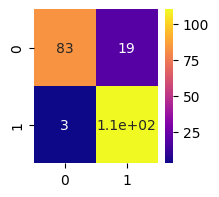

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
sns.heatmap(cm1,cmap='plasma',annot=True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(y_test,y_predic1)}")
print(f"Recall: {recall_score(y_test,y_predic1)}")
print(f"Precision: {precision_score(y_test,y_predic1)}")

Accuracy: 0.8976744186046511
Recall: 0.9734513274336283
Precision: 0.8527131782945736


## Usando sklearn

Usemos la implementación del clasificador Naive-Bayes de scikit-learn: 

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Realiza el entrenamiento y obten las predicciones para el conjunto de prueba

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np

clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)


MultinomialNB()

In [ ]:
y_predic2 = clf_nb.predict(X_test)
print(y_predic2)

[1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1
 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0
 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1
 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1
 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0]


Obten las métricas de rendimiento y la matriz de confusión.

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {accuracy_score(y_test,y_predic2)}")
print(f"Recall: {recall_score(y_test,y_predic2)}")
print(f"Precision: {precision_score(y_test,y_predic2)}")

Accuracy: 0.9348837209302325
Recall: 0.9734513274336283
Precision: 0.9090909090909091


In [ ]:
from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(y_test,y_predic2)
cm2

array([[ 91,  11],
       [  3, 110]])

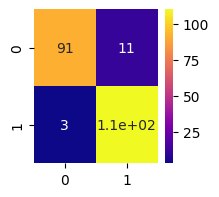

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(2,2))
sns.heatmap(cm2,cmap='plasma',annot=True)
plt.show()

<Figure size 10x10 with 0 Axes>

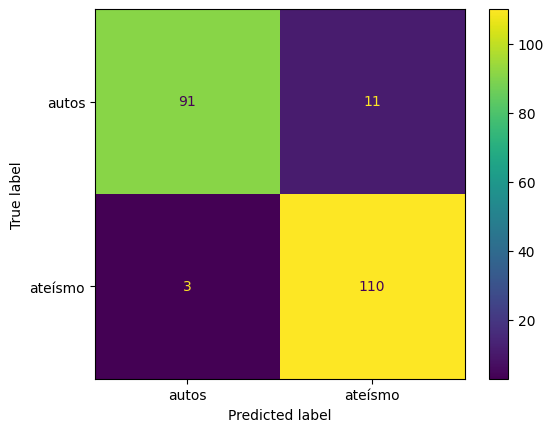

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


plt.figure(figsize=(.1,.1))
#sns.heatmap(cm,cmap='plasma',annot=True)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['autos', 'ateísmo' ])
cm_display.plot()
plt.show()